# Neutrino Parameter Estimation from Oscillation Probability Maps using MCMC

## Generate random inputs: Maps after Matter Effect

We use a simulator that generates 9 oscillation probability maps:

| Transition ↓ / Source → | $\nu_e$ (source) | $\nu_\mu$ (source) | $\nu_\tau$ (source) |
|--------------------------|------------------|--------------------|---------------------|
| **$\nu_e$ (detected)**  | $P(\nu_e \leftarrow \nu_e)$ | $P(\nu_e \leftarrow \nu_\mu)$ | $P(\nu_e \leftarrow \nu_\tau)$ |
| **$\nu_\mu$ (detected)** | $P(\nu_\mu \leftarrow \nu_e)$ | $P(\nu_\mu \leftarrow \nu_\mu)$ | $P(\nu_\mu \leftarrow \nu_\tau)$ |
| **$\nu_\tau$ (detected)** | $P(\nu_\tau \leftarrow \nu_e)$ | $P(\nu_\tau \leftarrow \nu_\mu)$ | $P(\nu_\tau \leftarrow \nu_\tau)$ |


If using **Google Colab**, use a GPU following these steps: *Runtime*->*Change runtime type*->*Select an available GPU option*.

In [ ]:
# Install NuOscParam library
!pip install -q git+https://github.com/GiorgioMorales/NuOscParam

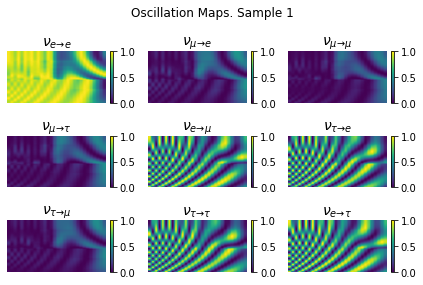

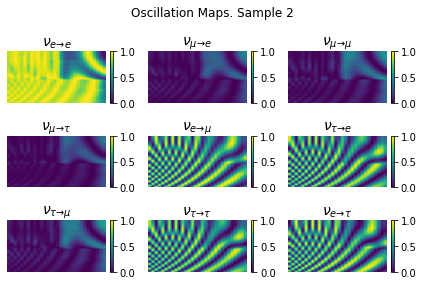

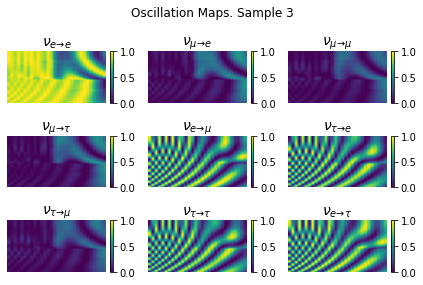

In [1]:
from NuOscParam.utils import *
from NuOscParam.Data.DataRanges import *
from NuOscParam.Data.OscIterableDataset import OscIterableDataset
%matplotlib inline

# Configure generator
generator = iter(OscIterableDataset(ranges=NEUTRINO_RANGES, pred_param="ALL", return_params=True, mode='earth',
                                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
# Generate three random maps
X_test, Osc_params = [], []
n_samples = 3
for i in range(n_samples):
    xtest, _, osc_pars, _ = next(generator)  # Generate 1 sample
    X_test.append(xtest)
    Osc_params.append(osc_pars)
    # Plot oscillation maps
    input_image = xtest[0, :, :, :].permute(1, 2, 0)
    plot_osc_maps(input_image, title=f"Oscillation Maps. Sample {i+1}")
X_test = torch.cat(X_test, dim=0)

## Delayed-acceptance MCMC Demonstration

This is a demonstration of the delayed-acceptance MCMC procedure, which, in our paper, was used as a baseline method for comparison. The `evaluate` method returns the MCMC predicions as well as the 90% confidence intervals (CIs) (*Note that a CI is not the same as a prediction interval)

In [2]:
from NuOscParam.MCMC.RunMCMC import RunMCMC
executor = RunMCMC(mode="earth")
pred_OscParams = executor.evaluate(X_test)

  0%|          | 0/3 [00:00<?, ?it/s]


*************************************************
Analyzing sample 1/3
*************************************************


 33%|███▎      | 1/3 [07:11<14:23, 431.62s/it]

	Inferred parameters:  [33.003803, 51.50117, 8.243288, 243.95, 7.993506e-05, 0.0024312385]
	CI Lower bounds:  [32.98322994128887, 51.22040140559516, 8.24357282164408, 233.34689815506738, 7.991574116056238e-05, 0.002431163419513187]
	CI Upper bounds:  [33.12059650612568, 51.534422413504636, 8.253910211763554, 244.80653003026399, 8.008810154025572e-05, 0.002431239936734519]

*************************************************
Analyzing sample 2/3
*************************************************


 67%|██████▋   | 2/3 [14:47<07:26, 446.00s/it]

	Inferred parameters:  [35.83292, 40.234528, 8.911714, 291.44995, 6.823634e-05, 0.0025989898]
	CI Lower bounds:  [35.8077282767418, 40.14092697651437, 8.909497193959545, 290.908588349152, 6.823230945317614e-05, 0.002598950833969814]
	CI Upper bounds:  [35.83571389699395, 41.201353899799145, 8.937867875691937, 297.10035366907, 6.828492295929742e-05, 0.002598993401510744]

*************************************************
Analyzing sample 3/3
*************************************************


100%|██████████| 3/3 [20:58<00:00, 419.62s/it]

	Inferred parameters:  [31.36036, 51.079937, 8.215369, 362.51404, 7.920741e-05, 0.0024311491]
	CI Lower bounds:  [31.292869051391925, 51.03385295518159, 8.20018903513, 301.5569913655886, 7.911963537877611e-05, 0.0024310201396872348]
	CI Upper bounds:  [32.009794322101904, 51.60416401360563, 8.381454807794784, 367.4651346960924, 7.99612123768391e-05, 0.0024311607248688476]


In [3]:
import pandas as pd
param_names = [r"$\theta_{12}$", r"$\theta_{23}$", r"$\theta_{13}$", r"$\delta_{CP}$", r"$\Delta m^2_{21}$", r"$\Delta m^2_{31}$"]
for i in range(n_samples):
    print("*" * 80)
    print(f"Results: Sample {i + 1}")
    print("*" * 80)
    df = pd.DataFrame({"Original": Osc_params[i].cpu().numpy().flatten(),
                       "CI Lower Bound": pred_OscParams[2][i, :].flatten(),
                       "Predicted": pred_OscParams[0][i, :].flatten(),
                       "CI Upper Bound": pred_OscParams[1][i, :].flatten()}, index=param_names)
    display(df)

********************************************************************************
Results: Sample 1
********************************************************************************


,Original,CI Lower Bound,Predicted,CI Upper Bound
$\theta_{12}$,34.756081,32.983230,33.003803,33.120597
$\theta_{23}$,46.226715,51.220401,51.501171,51.534422
$\theta_{13}$,8.899319,8.243573,8.243288,8.253910
$\delta_{CP}$,250.728546,233.346898,243.949997,244.806530
$\Delta m^2_{21}$,0.000079,0.000080,0.000080,0.000080
$\Delta m^2_{31}$,0.002348,0.002431,0.002431,0.002431


********************************************************************************
Results: Sample 2
********************************************************************************


,Original,CI Lower Bound,Predicted,CI Upper Bound
$\theta_{12}$,35.496395,35.807728,35.832920,35.835714
$\theta_{23}$,41.093628,40.140927,40.234528,41.201354
$\theta_{13}$,8.717807,8.909497,8.911714,8.937868
$\delta_{CP}$,290.715210,290.908588,291.449951,297.100354
$\Delta m^2_{21}$,0.000071,0.000068,0.000068,0.000068
$\Delta m^2_{31}$,0.002641,0.002599,0.002599,0.002599


********************************************************************************
Results: Sample 3
********************************************************************************


,Original,CI Lower Bound,Predicted,CI Upper Bound
$\theta_{12}$,32.402935,31.292869,31.360359,32.009794
$\theta_{23}$,48.451740,51.033853,51.079937,51.604164
$\theta_{13}$,8.485967,8.200189,8.215369,8.381455
$\delta_{CP}$,300.424866,301.556991,362.514038,367.465135
$\Delta m^2_{21}$,0.000067,0.000079,0.000079,0.000080
$\Delta m^2_{31}$,0.002344,0.002431,0.002431,0.002431
